<a href="https://colab.research.google.com/github/SergeiVKalinin/ML-ElectronMicroscopy-2023/blob/main/Lecture%207/Lecture_7_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Virtual Summer School: Machine Learning in Electron Microscopy
#Linear methods and dimensionality reduction for image data

Lecture 7, June 27

- Notebook by Mani Valleti, UT Knoxville
- Modified by Sergei V. Kalinin, UT Knoxville

First, let's make all the installations. We will be using the AtomAI package by Maxim Ziatdinov, https://github.com/pycroscopy/atomai/, in order to create the patch collection from image.

In [1]:
!pip install -q atomai  # We will use this

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import atomai as aoi

from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 46.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 45.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.


# Uniform Grid on NiO_LSMO

Let's experiment with the uniform grid sampling, or sliding window. We will use the STEM image of the NiO-LSMO system acquired by Matt Chisholm. This data set was used in https://www.nature.com/articles/s41524-021-00621-6

In [2]:
# Downloading the dataset
# I saved the dm3 file as a np array for easier access
!gdown 1i_FdNZKbYYTMW4JYbSOqdIXKNcdhlI52

Downloading...
From: https://drive.google.com/uc?id=1i_FdNZKbYYTMW4JYbSOqdIXKNcdhlI52
To: /content/NiO_LSMO.npy
100% 4.19M/4.19M [00:00<00:00, 76.2MB/s]


(-0.5, 1023.5, -0.5, 1023.5)

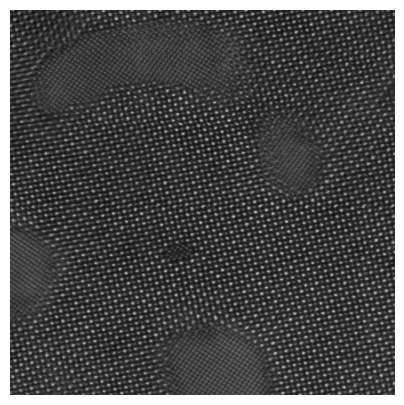

In [3]:
# Load the data and visualize
img = np.load('NiO_LSMO.npy')
fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(img, cmap = 'gray', origin = 'lower')
ax.axis('off')

You can clearly see on the image the perovskite (LSMO) and rock salt (NiO) regions. Now, let's create our descriptors using the AtomAI get_coord_grid function.

In [50]:
# Getting patches from data on a uniformly sampled grid
# The following parameters determine the step size of the grid and the size of each patch

window_size = 64 #48
step_size = 8

coordinates = aoi.utils.get_coord_grid(img, step_size)
coords = coordinates[0]
imstack_grid_nio, com_grid_nio, frames_grid_nio = aoi.utils.extract_subimages(img, coordinates, window_size)
print(imstack_grid_nio.shape)

(14641, 64, 64, 1)


Feel free to experiment with the objects we created. Com_grid is the array of coordinates of the center of patches, frames_grid is the frame from which they came. As you can deduce from this logic, AtomAI is made to work equally well for images or image stacks.

In [5]:
com_grid_nio

array([[  16.,   16.],
       [  16.,   24.],
       [  16.,   32.],
       ...,
       [1008.,  992.],
       [1008., 1000.],
       [1008., 1008.]])

In [6]:
print(com_grid_nio.shape)
print(frames_grid_nio.shape)
frames_grid_nio

(15625, 2)
(15625,)


array([0, 0, 0, ..., 0, 0, 0])

Now, let's make a function that will calculate FFT on th eimages in the image stack. As usual, we use fftshift to make sure that the k = 0 vector is in the center of the image.

In [35]:
import numpy as np

def apply_fourier_transform(array):
    # Get the dimensions of the input array
    a, b, c, d = array.shape

    # Perform Fourier transform on dimensions b and c
    transformed = np.fft.fft2(array, axes=(1, 2))

    # Calculate the magnitude of the transformed values
    magnitude = np.abs(transformed)

    # Rearrange the quadrants to shift the zero frequency component to the center
    shifted = np.fft.fftshift(magnitude, axes=(1, 2))

    # Map the shifted values back to the original array
    mapped_array = np.zeros_like(array, dtype=np.float64)
    mapped_array[:, :b, :c, :] = shifted

    return mapped_array

We apply it to the image stack

In [51]:
imstack_grid_nio_fft = apply_fourier_transform(imstack_grid_nio)
imstack_grid_nio_fft.shape

(14641, 64, 64, 1)

Now, let's choose which object we want to analyze - the original image stack, or its FFT. Results will be different!

In [52]:
imstack_analysis = imstack_grid_nio_fft

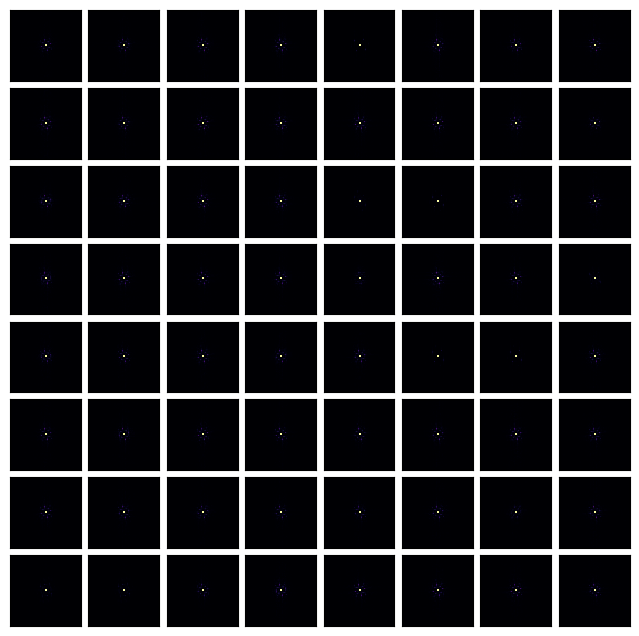

In [53]:
# Visualizing a few randomly selected patches from the dataset
np.random.seed(0)   # fix seed so that we get the same samples displayed at every run

fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack_analysis))
    ax.imshow(imstack_analysis[i,..., 0], cmap='inferno', interpolation='nearest', origin = 'lower')

In [54]:
# Feature Vector matrix
# Shape = [n_datapoints, n_features]
# The features of each image patch is the flattened patch of size (window_size*window_size)

X_nio = imstack_analysis[..., 0].reshape([-1, window_size*window_size])

In [62]:
# Gaussian Mixture modeling on the dataset
# This cell takes about 5 minutes to run
# If you do not have time, you can load the class centers and the labels of individual patches in the next cell

nc= 4
gmm = GMM(n_components=nc).fit(X_nio)
nio_labels = gmm.predict(X_nio)
nio_centers = gmm.means_

In [13]:
# Downloading the results of GMM

'''
!gdown 1EUJ7Q1kRq57Xf5C07UFg7zDv1khNwRru
!gdown 1cUm4kZH7wvcq5CzLyhgiyIVt39RMuiRW

nio_labels = np.load('nio_labels.npy')
nio_centers = np.load('nio_centers.npy')
'''

"\n!gdown 1EUJ7Q1kRq57Xf5C07UFg7zDv1khNwRru\n!gdown 1cUm4kZH7wvcq5CzLyhgiyIVt39RMuiRW\n\nnio_labels = np.load('nio_labels.npy')\nnio_centers = np.load('nio_centers.npy')\n"

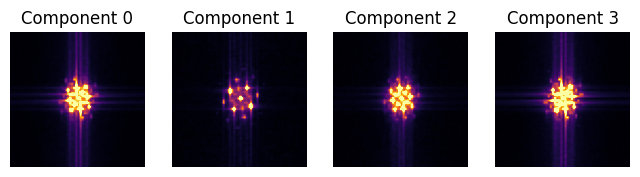

In [63]:
# Vizulaizing the GMM centers

rows, cols = 2, 4
gs2 = gridspec.GridSpec(rows, cols)

fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))

for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(nio_centers[i,:].reshape(window_size, window_size), cmap = 'inferno', origin = 'lower', vmax = 20)
    ax2.set_title('Component ' + str(i))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

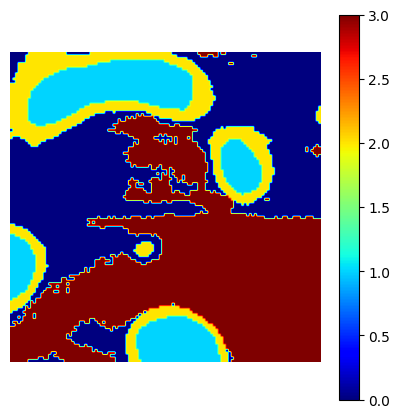

In [64]:
# Image centers colored using GMM classes
ss = int(int(nio_labels.shape[0])**(1/2))

plt.figure(figsize = (5,5))
z_img = nio_labels.reshape(ss,ss)
plt.imshow(z_img, origin = 'lower', cmap = 'jet')
plt.axis('off')
plt.colorbar()

Experiment with the effect of window size and number of components for analysis - for original data and FFT data.

Text(0, 0.5, 'explained variance (percent)')

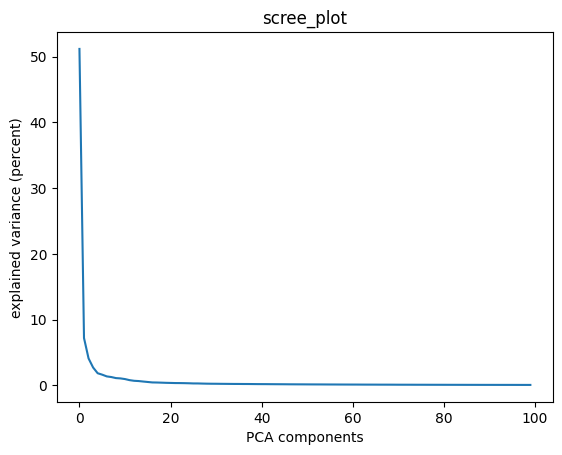

In [58]:
# We will also apply PCA on the image patches
pca = PCA(n_components = 100)
pca_load = pca.fit_transform(X_nio)
pca_components = pca.components_

plt.plot(np.arange(100), pca.explained_variance_ratio_*100)
plt.title('scree_plot')
plt.xlabel('PCA components')
plt.ylabel('explained variance (percent)')

Loading Maps


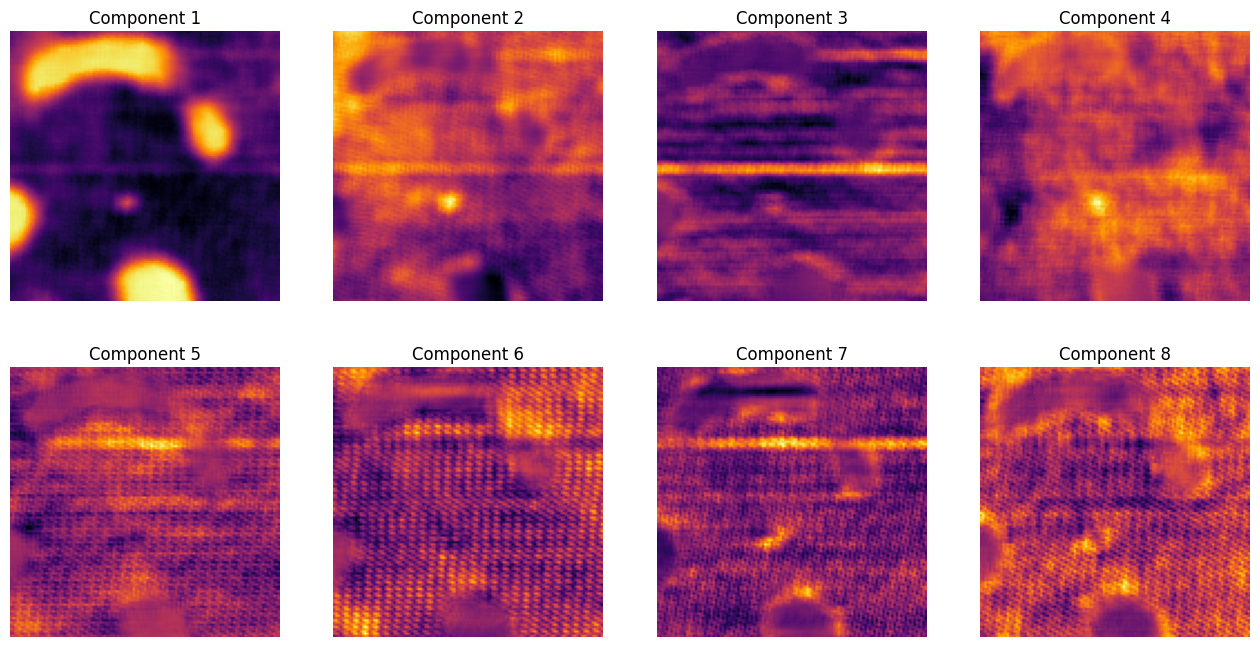

In [59]:
# Visulaizing the Loading maps

print('Loading Maps')
rows, cols = 2, 4
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(8):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(pca_load[:,i].reshape(ss, ss), cmap = 'inferno', origin = 'lower')
    ax2.set_title('Component ' + str(i+1))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

Loading Maps


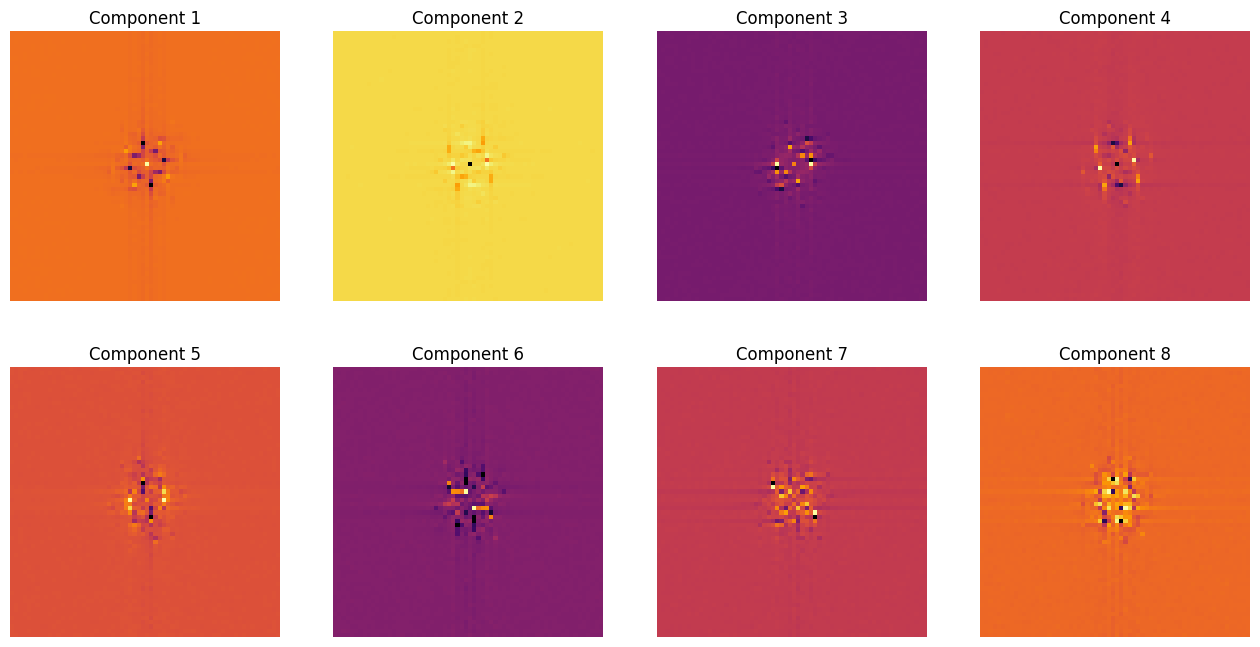

In [60]:
# Visualizing Principal Components (axes)

print('Loading Maps')
rows, cols = 2, 4
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(8):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(pca_components[i,:].reshape(window_size, window_size), cmap = 'inferno', origin = 'lower')
    ax2.set_title('Component ' + str(i+1))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

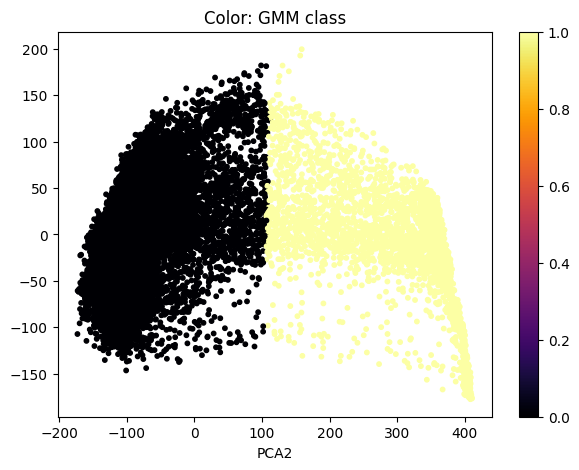

In [61]:
fig, ax = plt.subplots(figsize = (7,5))
scatter_plot = ax.scatter(pca_load[:,0], pca_load[:,1], c = nio_labels, cmap = 'inferno', s = 10)
ax.set_xlabel('PCA1')
ax.set_xlabel('PCA2')
ax.set_title('Color: GMM class')
plt.colorbar(scatter_plot, ax=ax)

# Ferroelectric domains from images centered around atoms

Now, let's experiment with the linear analysis for descriptors centered on atoms. This analysis was developed in https://pubs.aip.org/aip/adv/article/12/10/105122/2819887/Unsupervised-learning-of-ferroic-variants-from

In [20]:
!pip install -q atomai

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import atomai as aoi

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE, MDS, Isomap

Here, we download the raw data, the results of the semantic segmentation analysis, and atomic coordinates. You will learn later in the course how to make label the data, build and train the DCNNs, and segment the data.  

In [22]:
!gdown 1qZZeo-KggNzarQlIiYa9rObvuhvkmAcf
!gdown 1-FtMClm80ExkF74D8ATmHvdRDw5M3DBv
!gdown 1eiiI0X2pQWnHXGyMnQQys4oSsB2JA74h

rawdata = np.load('ferro_raw_data.npy')    # Raw Data
dcnn_out = np.load('ferro_dcnn_output.npy')    # DCNN output
coord = np.load('ferro_com.npy')    # Atomic centers obtained from the DCNN output. The last column refers to A or B site

Downloading...
From: https://drive.google.com/uc?id=1qZZeo-KggNzarQlIiYa9rObvuhvkmAcf
To: /content/ferro_raw_data.npy
100% 1.83M/1.83M [00:00<00:00, 40.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-FtMClm80ExkF74D8ATmHvdRDw5M3DBv
To: /content/ferro_dcnn_output.npy
100% 11.1M/11.1M [00:00<00:00, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eiiI0X2pQWnHXGyMnQQys4oSsB2JA74h
To: /content/ferro_com.npy
100% 105k/105k [00:00<00:00, 22.0MB/s]


(-0.5, 1016.5, 899.5, -0.5)

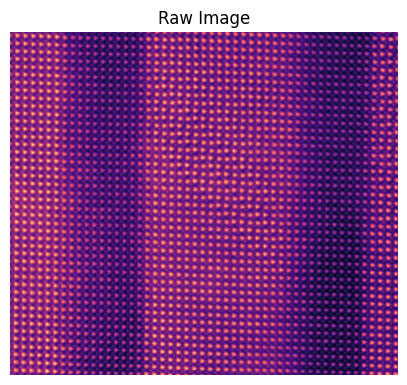

In [23]:
# Visualizing the raw image

plt.figure(figsize = (5,5))
plt.imshow(rawdata[0], cmap = 'magma')
plt.title('Raw Image')
plt.axis('off')

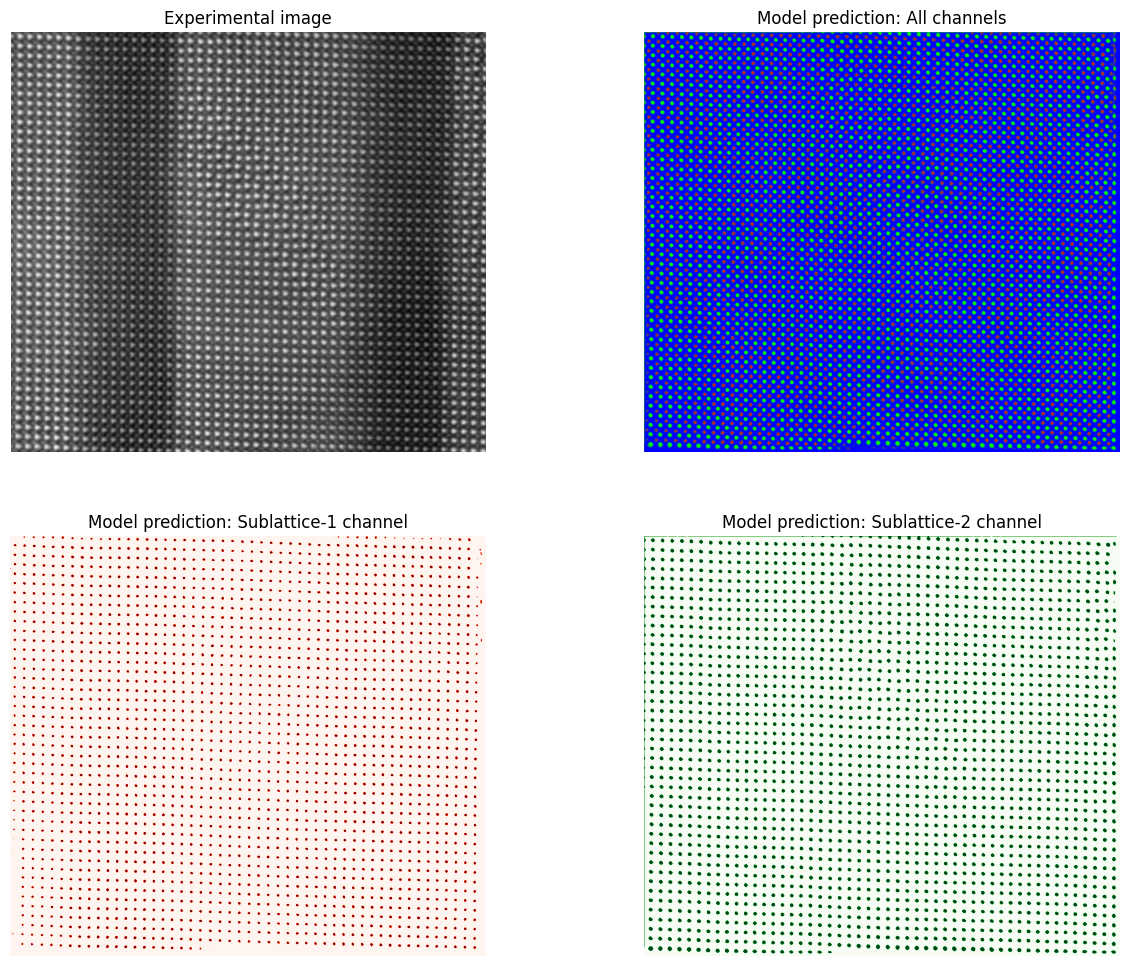

In [24]:
# Visualizing the semantically segmented DCNN output

fig, ax = plt.subplots(2, 2, figsize = (15, 12))
ax[0, 0].imshow(rawdata[0, :, :], cmap = 'gray')
ax[0, 0].set_title('Experimental image')
ax[0, 0].axis('off')
ax[0, 1].imshow(dcnn_out[0]) #Interpolation = 'Gaussian'
ax[0, 1].set_title('Model prediction: All channels')
ax[0, 1].axis('off')
ax[1, 0].imshow(dcnn_out[0,:,:,0]>0.5, cmap = 'Reds')
ax[1, 0].set_title('Model prediction: Sublattice-1 channel')
ax[1, 0].axis('off')
ax[1, 1].imshow(dcnn_out[0,:,:,1]>0.5, cmap = 'Greens')
ax[1, 1].set_title('Model prediction: Sublattice-2 channel')
ax[1, 1].axis('off')
for ax_ in fig.axes:
    ax_.grid(False)

In [25]:
# Making the sub-image stack out of the original image

# We will work with a window size of 54, we reported the data for both 54 and 36 in the paper
window_size = 54 #24 36 54

#We Choose the raw data for further analysis (either raw image or DCNN output can be chosen if the consequences are understood)

imstack_single, com_single, frames_single = aoi.utils.extract_subimages(
    np.expand_dims(rawdata, axis = (3)), # convert to a single channel (no background)
    {'0': np.array(coord)},
    window_size,
    0) # choose which lattice use as reference i.e., the last column of the coord array
imstack_single = imstack_single[..., 0] # disregard single channel dim

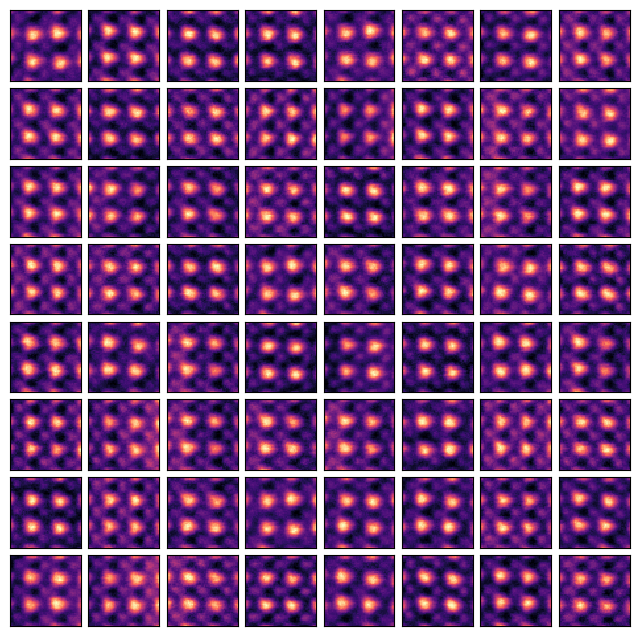

In [26]:
# Visualizing the sub-images
np.random.seed(0)   # fix seed so that we get the same samples displayed at every run

fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack_single))
    ax.imshow(imstack_single[i], cmap='magma', interpolation='nearest')

Let's start with kmeans clustering on the sub-image stack

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


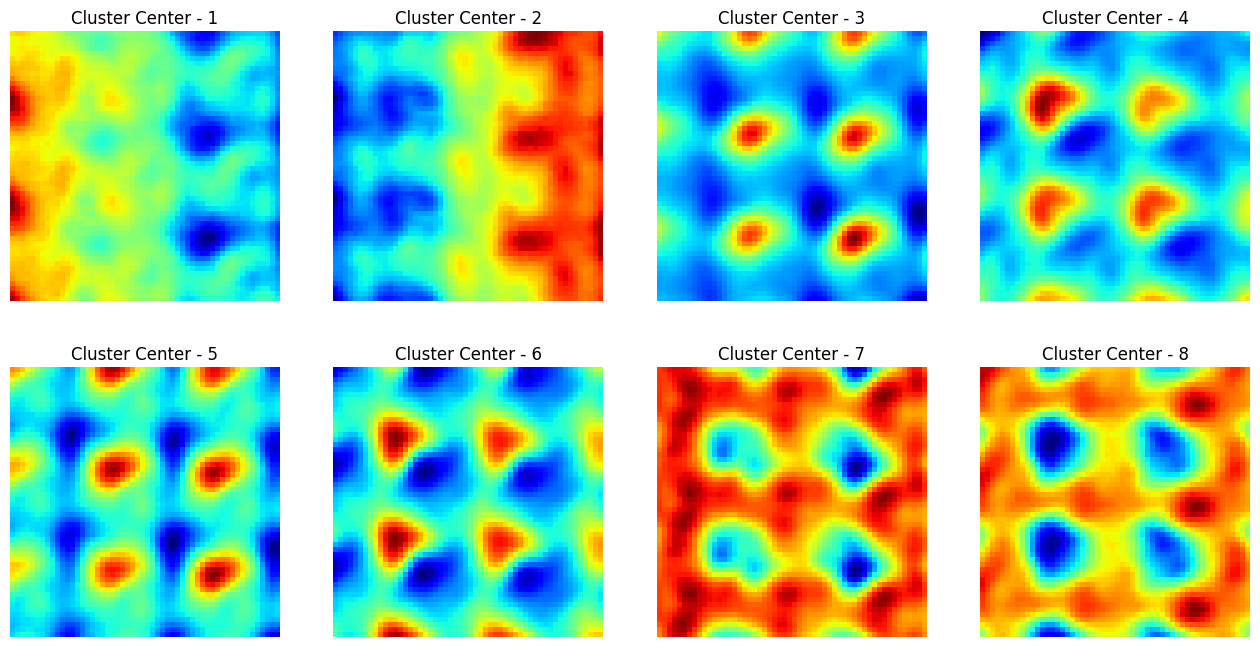

In [27]:
#kMeans on the cropped imagestack
z = imstack_single.reshape(-1, window_size*window_size)
im_av = imstack_single.mean(axis = 0)

nc = 8 #Try 4, 8, 16, 32
kmeans = KMeans(n_clusters=nc, random_state=0).fit(z)

rows = int(np.ceil(float(nc)/4))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(kmeans.cluster_centers_[i,:].reshape(window_size, window_size)-im_av, cmap = 'jet') #Average subtracted
    ax2.set_title('Cluster Center - ' + str(i + 1))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

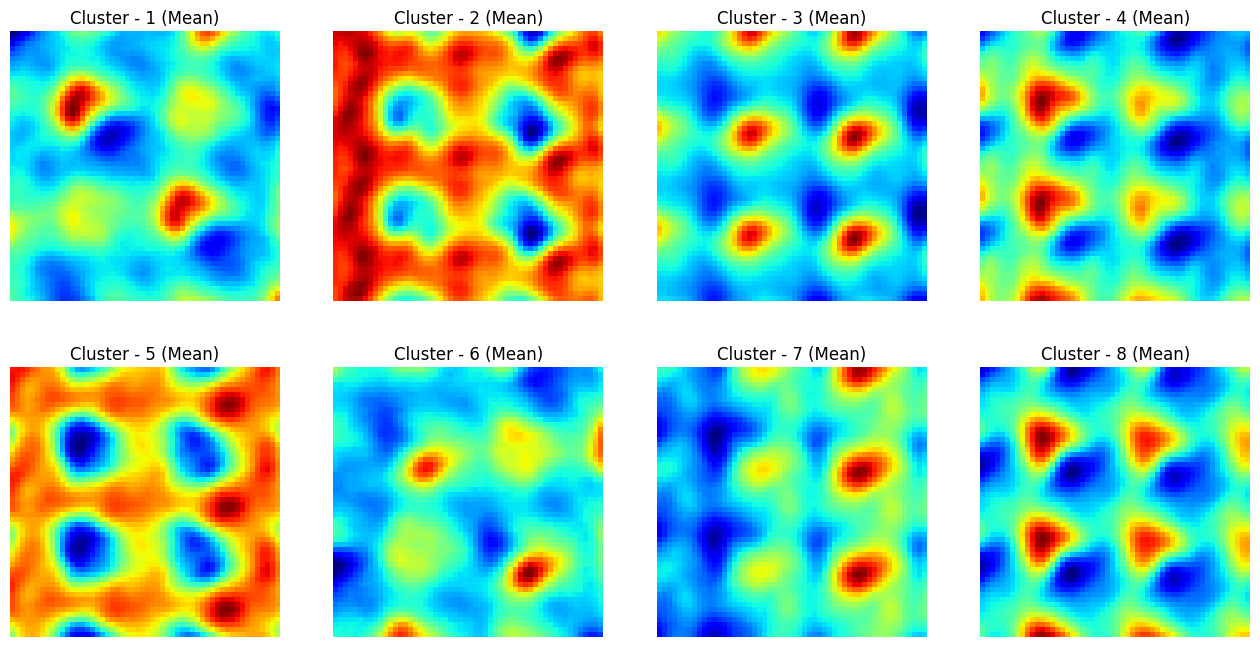

In [28]:
#GMM on cropped imagestack
z = imstack_single.reshape(-1, window_size*window_size)
nc = 8 #Try 4, 8, 16, 32

gmm = GaussianMixture(n_components=nc)
gmm_labels = gmm.fit_predict(z)

rows = int(np.ceil(float(nc)/4))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(gmm.means_[i,:].reshape(window_size, window_size) - im_av, cmap = 'jet')
    ax2.set_title('Cluster - ' + str(i + 1) + ' (Mean)' )
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

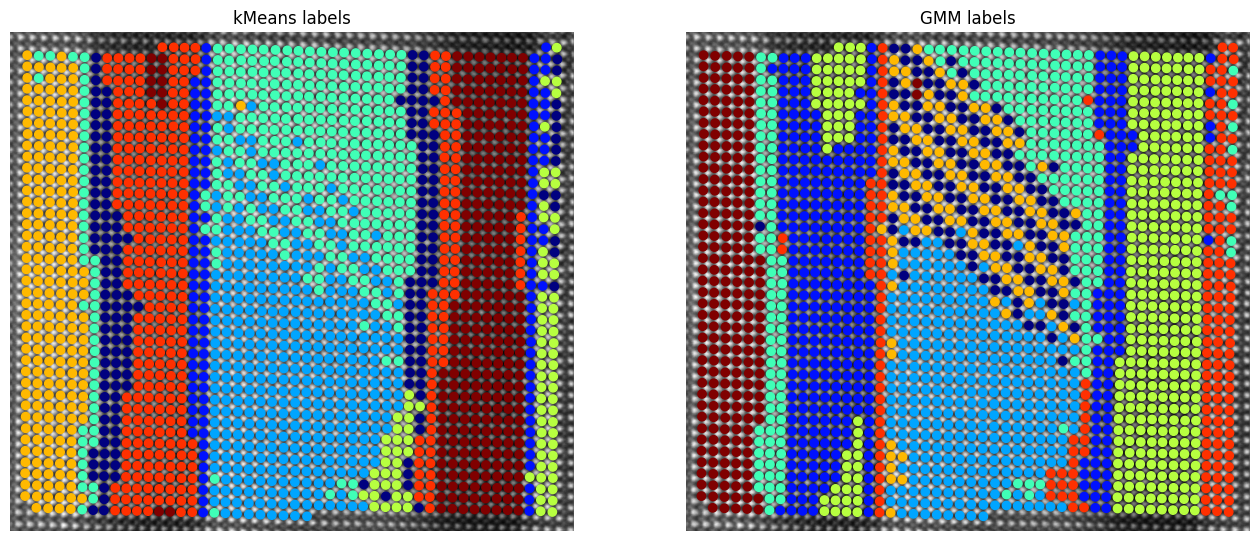

In [29]:
# Plots the image encoded by GMM or k-means labels

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,8))


ax[0].imshow(rawdata[0], cmap="gray")
ax[0].scatter(com_single[:, 1], com_single[:, 0], c=kmeans.labels_ , cmap = 'jet')
ax[0].set_title('kMeans labels')
ax[0].set_axis_off()


ax[1].imshow(rawdata[0], cmap="gray")
ax[1].scatter(com_single[:, 1], com_single[:, 0], c=gmm_labels , cmap = 'jet')
ax[1].set_title('GMM labels')
ax[1].set_axis_off()

A
B


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


C


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


D


Text(0.5, 1.0, 'ISO')

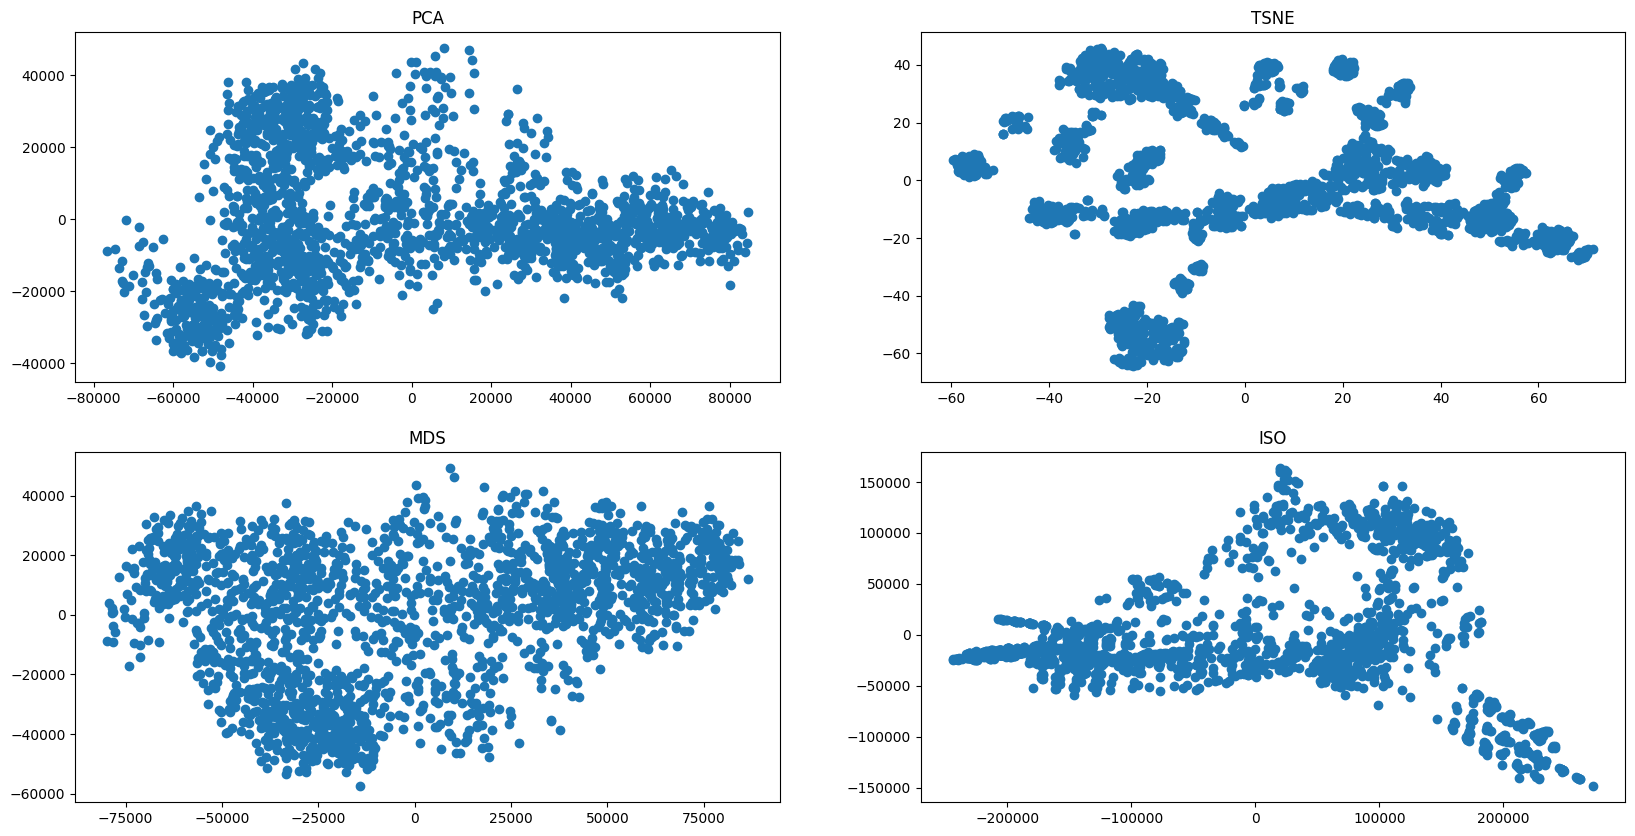

In [30]:
# Note that some of these are very time consuming, The whole cell should take around 3-5 minutes

z = imstack_single.reshape(-1, window_size*window_size)[:,::10]

#Principal Component Analysis
z_pca = PCA(n_components = 2).fit_transform(z)
print('A')

#t-distributed stochastic neighbor embedding
z_tsne = TSNE(learning_rate=200).fit_transform(z)
print('B')

#Multidimensional scaling
z_MDS = MDS(n_components = 2).fit_transform(z)
print('C')

#Isomap
z_ISO = Isomap(n_components = 2).fit_transform(z)
print('D')

plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('PCA')
plt.scatter(z_pca [:, 0], z_pca [:, 1])

plt.subplot(222)
plt.scatter(z_tsne[:, 0], z_tsne[:, 1])
plt.title('TSNE')

plt.subplot(223)
plt.scatter(z_MDS[:, 0], z_MDS[:, 1])
plt.title('MDS')

plt.subplot(224)
plt.scatter(z_ISO[:, 0], z_ISO[:, 1])
plt.title('ISO')

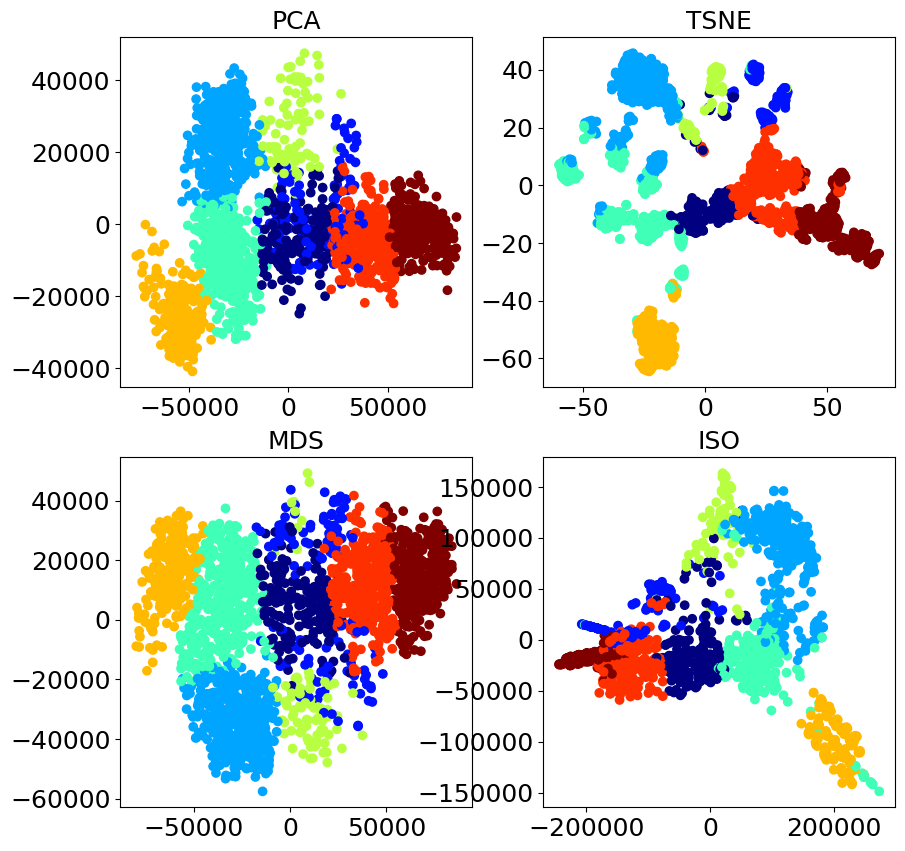

In [31]:
# Plot kMeans and GMM clustering in the reduced dimensionality space
# Using k-means or GMM labels as color
# So you can see how different strucutres are organized
# Use gmm_zpp or kmeans.labels_ to compare

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title('PCA', fontsize = 18)
plt.scatter(z_pca [:, 0], z_pca [:, 1], c = kmeans.labels_, cmap = 'jet') #kmeans.labels_
plt.tick_params(labelsize = 18)

plt.subplot(222)
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c = kmeans.labels_, cmap = 'jet')
plt.title('TSNE', fontsize = 18)
plt.tick_params(labelsize = 18)

plt.subplot(223)
plt.scatter(z_MDS[:, 0], z_MDS[:, 1], c = kmeans.labels_, cmap = 'jet')
plt.title('MDS', fontsize = 18)
plt.tick_params(labelsize = 18)

plt.subplot(224)
plt.scatter(z_ISO[:, 0], z_ISO[:, 1], c = kmeans.labels_, cmap = 'jet')
plt.title('ISO', fontsize = 18)
plt.tick_params(labelsize = 18)